# Import

In [156]:
import os
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from PIL import Image
torch.manual_seed(0)

# Load Data

In [157]:
def load_image_dataset(dataset_dir, shuffle=False):

    dataset_dir = Path(dataset_dir)

    images_paths = []
    labels = []

    # iterate through each image folder
    for c in os.listdir(dataset_dir):
        c_dir = dataset_dir / c
        # if not a folder, continue
        if os.path.isfile(c_dir):
            continue
        # list all images inside image folder
        images = os.listdir(c_dir)
        # append to list
        for image in images:
            # if in image format, append to list
            image_formats = ["jpg", "jpeg", "png"]
            if any(image.endswith(ext) for ext in image_formats):
                image_path = c_dir / image
                images_paths.append(image_path)
                labels.append(c)

    # shuffle dataset
    if shuffle:
        import random

        random.seed(0)
        indices = list(zip(images_paths, labels))
        random.shuffle(indices)
        images_paths, labels = zip(*indices)

    return images_paths, labels

In [158]:
x_train, y_train = load_image_dataset("dataset/cat-dog/train", shuffle=True)
x_test, y_test = load_image_dataset("dataset/cat-dog/test", shuffle=True)

In [159]:
x_train[:5], y_train[:5]

((PosixPath('dataset/cat-dog/train/dogs/dog_103.jpg'),
  PosixPath('dataset/cat-dog/train/cats/cat_557.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_269.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_178.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_290.jpg')),
 ('dogs', 'cats', 'dogs', 'dogs', 'dogs'))

In [160]:
x_test[:5], y_test[:5]

((PosixPath('dataset/cat-dog/test/cats/cat_244.jpg'),
  PosixPath('dataset/cat-dog/test/cats/cat_538.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_369.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_442.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_464.jpg')),
 ('cats', 'cats', 'dogs', 'dogs', 'dogs'))

In [161]:
print(len(x_train), len(y_train))

557 557


In [162]:
class ImageDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None) -> None:
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, index: int):
        x = Image.open(self.x[index]).convert("RGB")
        y = self.y[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def target_transform(x, reverse=False):
    map_ = {
        "cats": 0,
        "dogs": 1,
    }
    if reverse:
        map_ = {int(v): k for k, v in map_.items()}
        return map_.get(x)
    else:
        return torch.tensor(map_.get(x), dtype=torch.float32).reshape(1)


train_val_dataset = ImageDataset(
    x_train, y_train, transform=transform, target_transform=target_transform
)
n_train_val = len(train_val_dataset)
n_val = int(len(train_val_dataset) * 0.2)
n_train = n_train_val - n_val
train_dataset, val_dataset = random_split(train_val_dataset, lengths=[n_train, n_val])
test_dataset = ImageDataset(
    x_test, y_test, transform=transform, target_transform=target_transform
)

In [163]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [164]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, channel, H, W)
    print(f"Inputs range: {inputs.max().item(), inputs.min().item()}")  # Should be (batch_size, channel, H, W)
    print(f"Targets shape: {targets.shape}")  # Should be (batch_size)
    print(f"Targets: {targets}") 

    break

Batch 1
Inputs shape: torch.Size([16, 3, 224, 224])
Inputs range: (1.0000004768371582, -1.0)
Targets shape: torch.Size([16, 1])
Targets: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


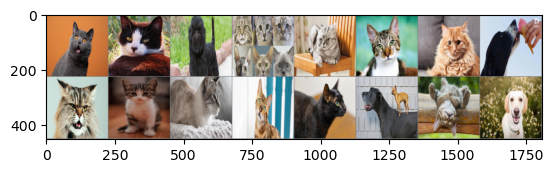

cats cats dogs cats cats cats cats dogs cats cats cats cats cats dogs cats dogs


In [165]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(
    " ".join(f"{target_transform(int(labels[j]), reverse=True)}" for j in range(batch_size))
)

# Model

In [166]:
class CNN(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(in_features=34992, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, x):   
        # conv layer
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2), stride=(2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2), stride=(2, 2))
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    
samples = torch.zeros(size=(8, 3, 224, 224))
sample_model = CNN()
sample_model(samples).shape

torch.Size([8, 1])

# Training

In [167]:
def train_one_step(model, x, y, optimizer, loss_fn):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def val_one_step(model, x, y, loss_fn):
    output = model(x)
    loss = loss_fn(output, y)
    return loss.item()


def train_one_epoch(model, input, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for batch_idx, (x, y) in enumerate(input):
        loss = train_one_step(model, x, y, optimizer, loss_fn)
        total_loss += loss
    # take the average loss of all batches
    return total_loss / (batch_idx + 1)  


def val_one_epoch(model, input, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(input):
            loss = val_one_step(model, x, y, loss_fn)
            total_loss += loss
    # take the average loss of all batches
    return total_loss / (batch_idx + 1)  


model = CNN()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
epochs = 10
print_step = 1


train_losses = []
val_losses = []
for epoch in range(epochs):

    # training
    train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)

    # validation
    val_loss = val_one_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

    if (epoch == 0) or ((epoch + 1) % print_step == 0):
        # print train and validation result
        avg_train_loss = np.mean(train_loss)
        avg_val_loss = np.mean(val_loss)
        print(
            f"Epoch {epoch+1: <3}/{epochs} | train BCE = {avg_train_loss: .8f} | val BCE = {avg_val_loss: .8f}"
        )

Epoch 1  /10 | train BCE =  0.74965402 | val BCE =  0.68657880
Epoch 2  /10 | train BCE =  0.67878738 | val BCE =  0.66137643
Epoch 3  /10 | train BCE =  0.60723945 | val BCE =  0.65365289
Epoch 4  /10 | train BCE =  0.38552613 | val BCE =  1.04050977
Epoch 5  /10 | train BCE =  0.16407758 | val BCE =  1.23249885
Epoch 6  /10 | train BCE =  0.12804332 | val BCE =  1.23650739
Epoch 7  /10 | train BCE =  0.04872082 | val BCE =  1.52767559
Epoch 8  /10 | train BCE =  0.02415410 | val BCE =  2.07289709
Epoch 9  /10 | train BCE =  0.00963096 | val BCE =  2.13280494
Epoch 10 /10 | train BCE =  0.00467213 | val BCE =  2.26155559


# Testing

In [168]:
test_loss = val_one_epoch(model, test_dataloader, loss_fn)
test_loss

2.1872973442077637

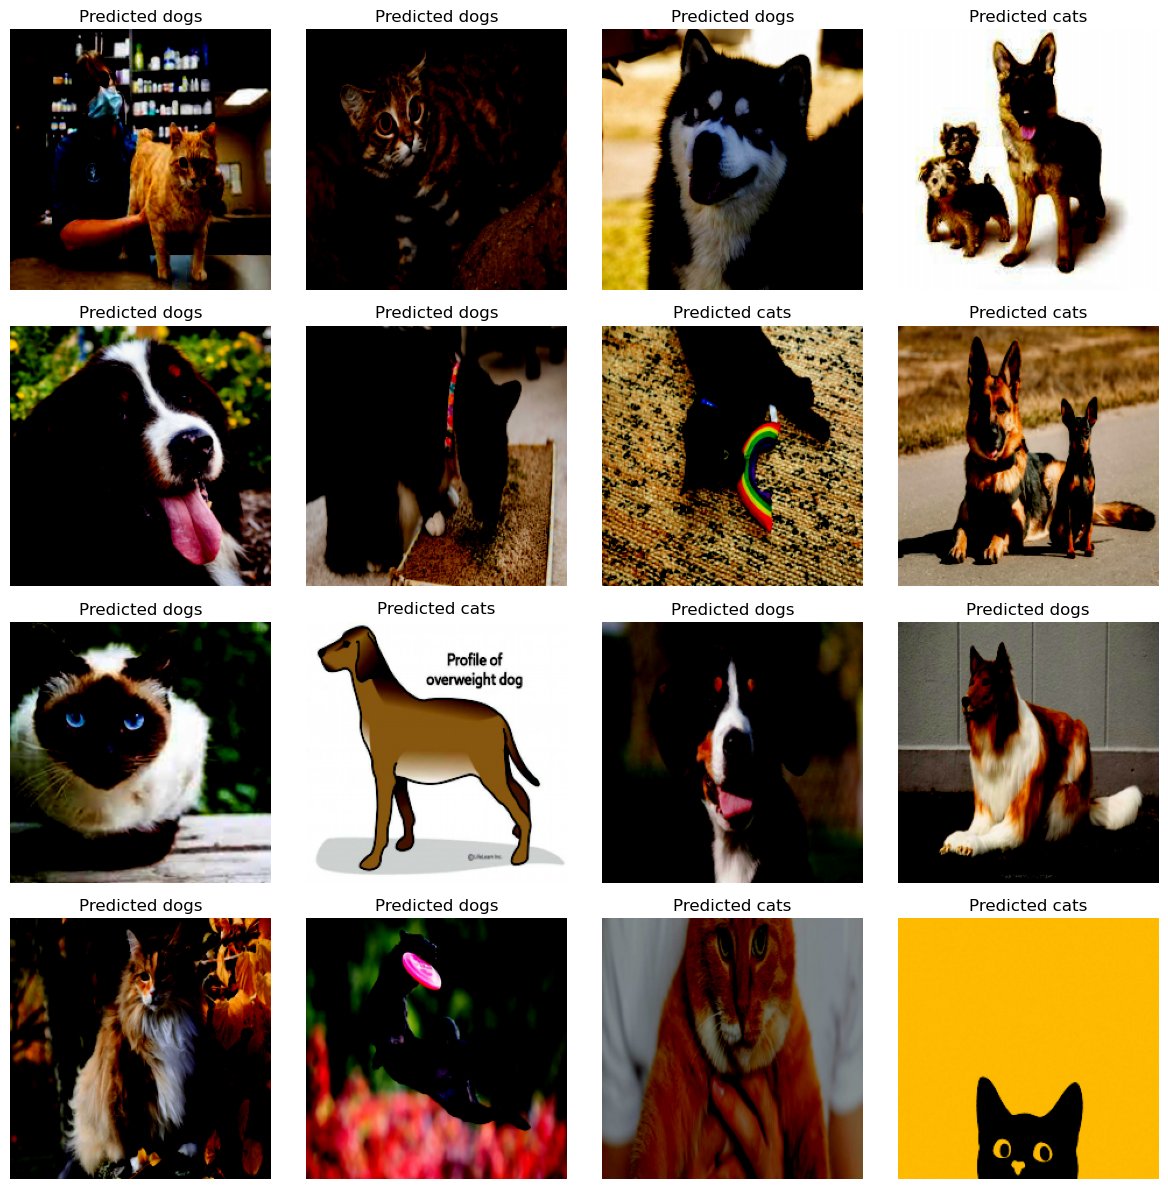

In [213]:
images = None
pred_labels = None
true_labels = None

for i, (x, y) in enumerate(test_dataloader):
    images = x.numpy()
    true_labels = y.numpy().flatten().astype(int)
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(x).numpy().flatten()
        y_pred = [int(y >= 0.5) for y in y_pred_proba]
        pred_labels = y_pred
    break


def show_images_in_grid(images, nrows, ncols, titles=None):
    """
    Displays images in a grid.

    Parameters:
    images (numpy.ndarray): A NumPy array of images with shape (n_batch, n_channel, H, W).
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        # convert the image from (n_channel, H, W) to ( H, W, n_channel)
        img = np.transpose(images[i], (1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.axis("off")

        if titles:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()


titles = [
    f"Predicted {target_transform(pred_label, reverse=True)}"
    for pred_label in pred_labels
]
show_images_in_grid(images, 4, 4, titles)